<h1> Example: Split a CNN Model into Two Parts </h1>

To run this example, [Google Colab](https://colab.research.google.com) is a recommended choice.

First of all, Clone!

In [1]:
!git clone https://github.com/nrasadi/split-keras-tensorflow-model

Cloning into 'split-keras-tensorflow-model'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 32), reused 12 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 472.50 KiB | 9.45 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [3]:
# Check if Colab is using gpu.
# If not, Runtime tab -> Change runtime type -> Hardware Accelarator (GPU)
gpu_name = !nvidia-smi -L
print("GPU name: ", gpu_name[0]) if len(gpu_name) >= 1 else print("No GPU!")

GPU name:  GPU 0: Tesla T4 (UUID: GPU-b7ef13c8-a792-6869-1e6a-73f8fa4d3a89)


In [2]:
from pathlib import Path
import os

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers as KL
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model

%matplotlib inline

In [3]:
os.chdir("/content/split-keras-tensorflow-model")
import splitter

FileNotFoundError: [Errno 2] No such file or directory: '/content/split-keras-tensorflow-model'

<h2> Load MNIST Dataset </h2>

It contains:
*   60000 train samples
*   10000 test samples



In [11]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


<h2> Visualize Dataset </h2>


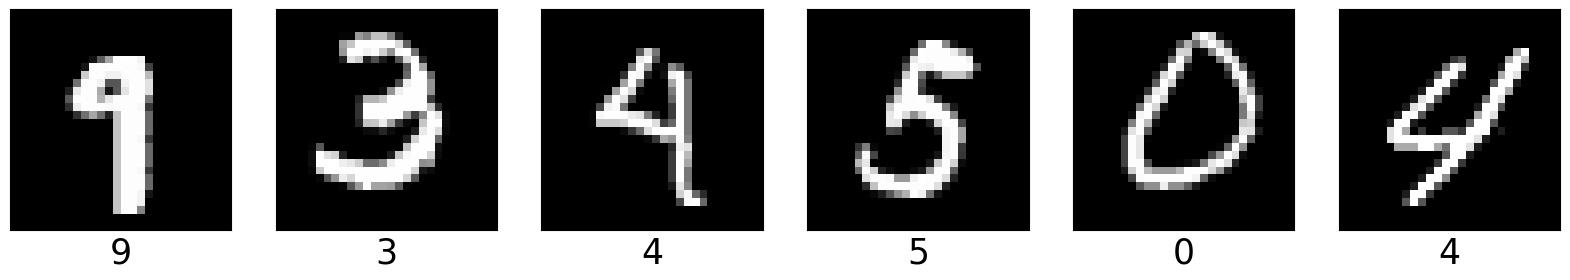

In [12]:
# Visualize dataset
plt.figure(figsize=(20,10))
sample_idx = np.random.randint(len(y_test), size=6)
for i in range(6):
  plt.subplot(161+i)
  plt.imshow(x_test[sample_idx[i]].reshape(28,28).astype(float), cmap='gray')
  # print("Label:", np.where(y_test[sample_idx] == 1)[0][0])
  # plt.axis("off")
  plt.xticks([]); plt.yticks([])
  plt.xlabel(str(np.where(y_test[sample_idx[i]] == 1)[0][0]), fontsize=25)
plt.show()

<h2> Design Digit Recognizer Model Architecture </h2>

<h3> Quantize the model </h3>

*   At first, I reduced the precision of weights and activations used in neural network to make the training process <b>faster</b>.
*   It may introduce accuracy instability on real models however. Therefore it's better to use float32 or [tensorflow mixed precision policy](https://www.tensorflow.org/guide/keras/mixed_precision) instead!

<h3> Apply augmentation </h3>

To prevent <b>overfitting</b> and boost the accuracy of the model, I used a few -very simple- augmentation techniques before feeding images to the DNN.

*   All the following techniques are stochastic with the degree determined by 'factor'.
*   dropout: simulates noise or pixel drop.
*   zoom: applies zoom-in and zoom-out on images. (i.e. image scaling.)
*   translation, rotation: translates and rotates images.
*   contrast: modifies contrast of images.

<h3> Model architecture design </h3>

I designed a ResNet-like architecture, but pretty much simpler and with way too less parameters.

It consists of 4 blocks:

1. Conv(16)-Conv(32)-MaxPooling
2. ResBlock: Conv(32)-Conv(32)
3. ResBlock: Conv(32)-Conv(32)
4. Conv(64)-Dense(128)-Dense(10)

* I applied *ReLU6* activation on residual blocks and *ReLU* on others
* 20% dropout is applied on all conv blocks after batch normalization.
* 50% dropout is applied just before last dense layer (output).

<h3> Model construction </h3>

I used *RMSProp* as the optimzer and *categorical cross entropy* as the loss function.

In [34]:


# Quantize the network (Reduce precision of weights and activations to float16)
# K.set_floatx('float16')

tf.keras.backend.set_floatx('float32')

# Apply some augmentation techniques on input images
factor = .1
augmentation = keras.Sequential(
    [
      # Set the dtype of the augmentation layers to float32
      KL.Dropout(0.001, name="drop_0", dtype='float32'),
      KL.RandomZoom((-factor, factor), name="zoom", dtype='float32'),
      KL.RandomTranslation((-factor, factor), (-factor, factor), name="translate", dtype='float32'),
      KL.RandomRotation((-factor, factor), name="rotate", dtype='float32'),
      KL.RandomContrast(factor, name="contrast", dtype='float32'),
    ], name="augmentation"
)

# Define Conv Block
def Conv(tensor, filter, k=3, activation='relu', drop_rate=.2, maxpool=False, name_pos="0"):
    """Constructs Conv2D layers"""

    x = KL.Conv2D(filter, k, name="conv_"+name_pos, padding="same")(tensor)
    x = KL.BatchNormalization(name="bn_"+name_pos)(x)

    if activation.lower() == 'relu6':
      x = KL.Activation(tf.nn.relu6, name="relu6_"+name_pos)(x)
    elif activation.lower() == 'swish':
      x = KL.Activation(tf.nn.swish, name="swish_"+name_pos)(x)
    else:
      x = KL.Activation('relu', name="relu_"+name_pos)(x)

    x = KL.Dropout(drop_rate, name="drop_"+name_pos)(x)

    if maxpool:
      x = KL.MaxPooling2D(3, name="maxp_"+name_pos)(x)

    return x

act = "relu6"

# Block 0
inp = keras.Input(shape=input_shape, name="input")
x = augmentation(inp)

# Block 1
x = Conv(x, 16, name_pos="1")
x1 = Conv(x, 32, maxpool=True, name_pos="2")

# Block 2
x = Conv(x1, 32, activation=act, name_pos="3")
x = Conv(x, 32, activation=act, name_pos="4")
x2 = KL.add([x, x1], name="add_1")

# Block 3
x = Conv(x2, 32, activation=act, name_pos="5")
x = Conv(x, 32, activation=act, name_pos="6")
x3 = KL.add([x, x2], name="split") # Split point

# Block 4
x = Conv(x3, 64, activation=act, name_pos="7")
# x = KL.GlobalAveragePooling2D(name="globavgp")(x)
x = KL.Flatten(name="Flatten")(x)
x = KL.Dense(128, activation='relu', name="dense_1")(x)
x = KL.Dropout(0.5, name="last_drop")(x)
out = KL.Dense(10, name="output", activation="softmax")(x)

# Create model
model = keras.Model(inp, out, name="digit_recognizer")
model.summary()

# Construct DAG
model.compile(loss="categorical_crossentropy", optimizer="RMSProp", metrics=["accuracy"])

Model: "digit_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 28, 28, 1) │          0 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 28, 28, 1) │          0 │ cast_1[0][0]      │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 28, 28, 1) │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 28, 28,    │        160 │ cast_2[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 28, 28,    │         64 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1 (Activation) │ (None, 28, 28,    │          0 │ bn_1[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 28, 28,    │          0 │ relu_1[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 28, 28,    │      4,640 │ drop_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 28, 28,    │        128 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2 (Activation) │ (None, 28, 28,    │          0 │ bn_2[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 28, 28,    │          0 │ relu_2[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxp_2              │ (None, 9, 9, 32)  │          0 │ drop_2[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 9, 9, 32)  │      9,248 │ maxp_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 9, 9, 32)  │        128 │ conv_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu6_3             │ (None, 9, 9, 32)  │          0 │ bn_3[0][0]        │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_3 (Dropout)    │ (None, 9, 9, 32)  │          0 │ relu6_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 9, 9, 32)  │      9,248 │ drop_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 9, 9, 32)  │        128 │ conv_4[0][0]    

 Total params: 726,218 (1.39 MB)

 Trainable params: 725,738 (1.38 MB)

 Non-trainable params: 480 (960.00 B)

<h2> Plot Graphical Visualization of the Network Architecture </h2>

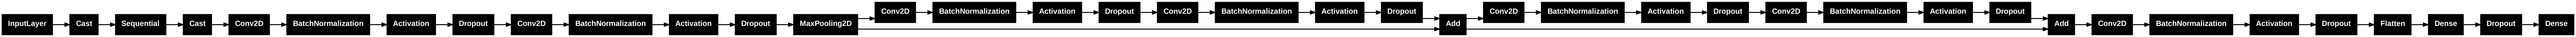

In [35]:
plot_model(model, rankdir='LR', dpi=600)

<h2> Train the Network </h2>

* Change batch size and number of epochs to fit best with the resources you have.

In [36]:
# Train the model
batch_size = 256
epochs = 200

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.4609 - loss: 1.7884 - val_accuracy: 0.2592 - val_loss: 2.4163
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8868 - loss: 0.3826 - val_accuracy: 0.4688 - val_loss: 1.8008
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9253 - loss: 0.2574 - val_accuracy: 0.9495 - val_loss: 0.2012
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9407 - loss: 0.2142 - val_accuracy: 0.9797 - val_loss: 0.0686
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9483 - loss: 0.1860 - val_accuracy: 0.9778 - val_loss: 0.0822
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9537 - loss: 0.1641 - val_accuracy: 0.9877 - val_loss: 0.0476
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9575 - loss: 0.1514 - val_accuracy: 0.9772 - val_loss: 0.1017
Epoch 8/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9596 - loss: 0.1472

<h2> Model Evaluation </h2>

Evaluate the model on the test set to see how good the network has been trained.


*  Having *batch_size=256* and *epochs=200*, the model should achieve ~99.2-99.5% accuracy on the test set



<h2> Split The Network </2>

After all, we want to split the network from a point called <b> split point </b>.
In the *Model architecture design* section, I named a specific layer (the second Add layer) as <b>'split'</b>. I want to split the model from that point now. Of course, you can choose a different point. It's on you!

* Make sure you have read the split_network document to have enough understanding about its arguments.
* After applying split_network, we have two models, head and tail, each one works separately.
* The split point itself belongs to the head model. You can move it to the tail model by turning the *on_head* argument into False.

In [40]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss: {:.4f}".format(score[0]))
print("Test accuracy: {:.2f}%".format(score[1]*100))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0835
Test loss: 0.0678
Test accuracy: 98.87%


In [1]:
from keras.models import load_model

model = load_model('num_model.keras')

In [8]:
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers as KL
from tensorflow.keras import Model, Input
import tensorflow as tf # Import tensorflow

def split_network(model, split_layer_name: str, on_head=True, names=('head', 'tail'), custom_objects: dict = None) -> (Model, Model):
    """
    Splits a Keras model into two sub-models at the specified layer.

    Arguments:
        model: Keras Model instance or path to saved model (str or Path).
        split_layer_name: The name of the layer to split on.
        on_head (optional): If True, split layer is included in head model. Otherwise in tail.
        names (optional): Tuple containing names for head and tail models.
        custom_objects (optional): Dictionary of custom objects needed to load model.

    Returns:
        (head_model, tail_model): Tuple of two Keras Model instances.
    """

    if not isinstance(model, Model):
        assert isinstance(model, (str, Path)), "model must be a Keras Model or a path to a saved model."
        model2split = keras.models.load_model(str(model), custom_objects=custom_objects)
    else:
        model2split = model

    # Get the layer to split at
    split_layer = model2split.get_layer(split_layer_name)

    # Define head model (from input to split layer output)
    head_output = split_layer.output if on_head else split_layer.input
    # Handle the case where split_layer.input is a list of tensors (e.g., for Add layer)
    if isinstance(head_output, list):
        head_output = head_output[0] # Use the first input tensor

    head_model = Model(inputs=model2split.input, outputs=head_output, name=names[0])

    # Define tail model
    # Use output of head model as input to tail
    if on_head:
        tail_input = Input(shape=split_layer.output_shape[1:], name='tail_input')
        x = tail_input
    else:
        # Handle the case where split_layer.input_shape is not available (e.g., for Add layer)
        if isinstance(split_layer.input, list):
            # Use the shape of the first input tensor to the split layer
            tail_input = Input(shape=split_layer.input[0].shape[1:], name='tail_input')
            x = split_layer([tail_input] + [Input(shape=inp.shape[1:]) for inp in split_layer.input[1:]]) # Reconstruct inputs for the split layer
        else:
             tail_input = Input(shape=split_layer.input_shape[1:], name='tail_input')
             x = split_layer(tail_input)


    # Reconstruct layers after the split
    found = False
    for layer in model2split.layers:
        if found:
            # Reconnect the layers. Need to handle layers that accept multiple inputs
            try:
                x = layer(x)
            except ValueError:
                # This handles layers like Add, Concatenate etc. that take multiple inputs.
                # We need to find the corresponding input tensors from the original model's output
                # before this layer and provide them to the current layer.
                layer_inputs = []
                # Find the node in the original model's graph that corresponds to the current layer
                original_layer_node = None
                for node in layer.inbound_nodes:
                    # Check if the input tensor name matches the current output 'x' in the new tail model
                    # This is a simplified approach, might need refinement for complex graphs
                     if isinstance(x, list):
                         for i, input_tensor in enumerate(x):
                             if input_tensor._keras_history.layer.name in [inbound_layer.name for inbound_layer in node.inbound_layers]:
                                layer_inputs.append(x[i])
                         if len(layer_inputs) == len(node.inbound_layers):
                             original_layer_node = node
                             break
                     else:
                          if x._keras_history.layer.name in [inbound_layer.name for inbound_layer in node.inbound_layers]:
                              original_layer_node = node
                              layer_inputs.append(x) # Simplified: assume x is the only input

                if original_layer_node:
                    # For layers with multiple inputs, we need to feed the output of the previous
                    # layer in the new tail model ('x') and the corresponding outputs from the
                    # original model's graph for the other inputs of the current layer.
                    # This part is complex and might require more sophisticated graph traversal.
                    # For simplicity, let's assume the primary input to the current layer is 'x'.
                    # If the layer takes multiple inputs, we need to find the other inputs
                    # based on the original model's graph.
                    # This is a placeholder and needs to be implemented based on the specific
                    # types of layers that cause this error.
                    # A more robust solution would involve mapping tensors from the original
                    # model's graph to the new tail model's graph.
                    print(f"Warning: Skipping complex layer reconstruction for layer '{layer.name}'. Manual intervention might be required.")
                    continue # Skip this layer for now

                else:
                     print(f"Warning: Could not find corresponding node for layer '{layer.name}'. Manual intervention might be required.")
                     continue # Skip this layer for now

        if layer.name == split_layer_name:
            found = True

    tail_model = Model(inputs=tail_input, outputs=x, name=names[1])

    return head_model, tail_model

In [17]:
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers as KL
from tensorflow.keras import Model, Input
import tensorflow as tf # Import tensorflow

def split_network2(model, split_layer_name: str, on_head=True, names=('head', 'tail'), custom_objects: dict = None) -> (Model, Model):
    """
    Splits a Keras model into two sub-models at the specified layer.

    Arguments:
        model: Keras Model instance or path to saved model (str or Path).
        split_layer_name: The name of the layer to split on.
        on_head (optional): If True, split layer is included in head model. Otherwise in tail.
                           NOTE: If the split layer takes multiple inputs (like Add),
                           setting on_head=False will effectively split *after* this layer
                           and its output will be the input to the tail.
        names (optional): Tuple containing names for head and tail models.
        custom_objects (optional): Dictionary of custom objects needed to load model.

    Returns:
        (head_model, tail_model): Tuple of two Keras Model instances.
    """

    if not isinstance(model, Model):
        assert isinstance(model, (str, Path)), "model must be a Keras Model or a path to a saved model."
        model2split = keras.models.load_model(str(model), custom_objects=custom_objects)
    else:
        model2split = model

    # Get the layer to split at
    split_layer = model2split.get_layer(split_layer_name)

    # Determine the effective split point for handling multi-input layers
    # If the split layer takes multiple inputs (e.g., Add, Concatenate) AND on_head is False,
    # we must split *after* this layer, making its output the input to the tail.
    # Otherwise, the split is precisely at the split layer's input/output based on on_head.
    effective_split_after_layer = False
    if hasattr(split_layer, '_inbound_nodes') and len(split_layer._inbound_nodes) > 0:
         # Check if the layer expects multiple inputs. This is a heuristic, might need refinement
         # Check the number of input tensors in the first inbound node
         if len(split_layer._inbound_nodes[0].input_tensors) > 1 and not on_head:
             effective_split_after_layer = True
             print(f"Info: Splitting after multi-input layer '{split_layer_name}' as on_head=False.")


    # Define head model
    if effective_split_after_layer:
        # Head output is the split layer's output
        head_output = split_layer.output
    else:
        # Head output is the split layer's output if on_head is True, otherwise its input
        head_output = split_layer.output if on_head else split_layer.input
        # Handle the case where split_layer.input is a list of tensors (e.g., for Add layer's input)
        if isinstance(head_output, list):
            # If the split is at the input of a multi-input layer, and on_head=False,
            # this scenario shouldn't happen with the effective_split_after_layer logic.
            # However, as a fallback, use the first input tensor as the output of the head.
            head_output = head_output[0]
            print(f"Warning: Head output for layer '{split_layer_name}' is a list, using the first tensor.")


    head_model = Model(inputs=model2split.input, outputs=head_output, name=names[0])

    # Define tail model
    if effective_split_after_layer or on_head:
        # The tail input is the output of the effective split point
        tail_input_shape = head_model.output_shape[1:]
        tail_input = Input(shape=tail_input_shape, name='tail_input')
        x = tail_input
        # Find the layer immediately following the split layer in the original model
        found_split = False
        start_layer_in_tail = None
        for layer in model2split.layers:
            if found_split:
                 start_layer_in_tail = layer
                 break
            if layer.name == split_layer_name:
                found_split = True

        if start_layer_in_tail:
            # Feed the tail_input into the layer that follows the split layer
             # Handle the case where the start layer takes multiple inputs.
             # This is still a complex scenario and might require manual handling
             # or a more sophisticated graph traversal. For simplicity, assume
             # the tail_input connects to the primary input of the start layer.
             try:
                x = start_layer_in_tail(x)
             except ValueError as e:
                 print(f"Error feeding tail_input into '{start_layer_in_tail.name}'. Manual reconstruction might be needed for complex connections.")
                 raise e # Re-raise the exception

        else:
            # If the split layer was the last layer of the original model, the tail is empty.
            print("Warning: Split layer is the last layer. Tail model will be empty.")
            tail_model = Model(inputs=tail_input, outputs=x, name=names[1]) # x is just the tail_input here
            return head_model, tail_model


    else: # on_head is False, and split layer is not multi-input
         # The tail input is the input of the split layer
         tail_input_shape = split_layer.input_shape[1:]
         tail_input = Input(shape=tail_input_shape, name='tail_input')
         # The first layer of the tail is the split layer itself
         x = split_layer(tail_input)


    # Reconstruct layers after the effective start of the tail
    found = False
    # Iterate through layers in the original model starting from the one after the split layer (or the split layer itself if on_head=False and not multi-input)
    start_adding_layers = False
    if effective_split_after_layer:
         start_adding_layers = False # Will start after the split layer
    elif on_head:
         start_adding_layers = False # Will start after the split layer
    else: # on_head is False, and split layer is not multi-input
         start_adding_layers = False # Will start from the split layer itself

    for layer in model2split.layers:
        if layer.name == split_layer_name:
            if not (effective_split_after_layer or on_head):
                 # If on_head is False and it's not a multi-input layer where we split after,
                 # the tail starts with the split layer, which we've already added as x.
                 pass # Already handled above
            start_adding_layers = True
            continue # Skip the split layer itself when starting from after it

        if start_adding_layers:
            # Reconnect the layers. Need to handle layers that accept multiple inputs
            try:
                x = layer(x)
            except ValueError:
                 # This still might happen for complex layer connections not handled
                 # by the effective_split_after_layer logic.
                 print(f"Warning: Skipping complex layer reconstruction for layer '{layer.name}'. Manual intervention might be required.")
                 # In a real scenario, you would need to handle these connections by
                 # mapping the outputs of previous layers in the new tail model to
                 # the inputs of the current multi-input layer based on the original graph.
                 continue # Skip this layer for now


    tail_model = Model(inputs=tail_input, outputs=x, name=names[1])

    return head_model, tail_model

In [19]:
# Find custom layers that are not pure Keras layers/objects, but brought directly by Tensorflow backend.
custom_layers = {}
for l in model.layers:
  name = l.name
  if "relu6" in name or "swish" in name:
    custom_layers[name] = l

# See what these custom layers are.
print(custom_layers)

# Get head and tail models after apllying split_network. Arguments are explained. Make sure you have read its document.
head, tail = split_network2(model=model,
                                    split_layer_name="split",
                                    on_head=False,
                                    names=("head_model", "tail_model"),
                                    custom_objects=custom_layers)

{'relu6_3': <Activation name=relu6_3, built=True>, 'relu6_4': <Activation name=relu6_4, built=True>, 'relu6_5': <Activation name=relu6_5, built=True>, 'relu6_6': <Activation name=relu6_6, built=True>, 'relu6_7': <Activation name=relu6_7, built=True>}
Info: Splitting after multi-input layer 'split' as on_head=False.


<h3> Let's see how these head and tail models are </h3>

In [20]:
_ = head.summary(line_length=100), tail.summary(line_length=100)

Model: "head_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)          │ (None, 28, 28, 1)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cast (Cast)                 │ (None, 28, 28, 1)       │              0 │ input[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cast_2 (Cast)               │ (None, 28, 28, 1)       │              0 │ cast[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ augmentation (Sequential)   │ (None, 28, 28, 1)       │              0 │ cast_2[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cast_1 (Cast)               │ (None, 28, 28, 1)       │              0 │ augmentation[0][0]      │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv_1 (Conv2D)             │ (None, 28, 28, 16)      │            160 │ cast_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_1 (BatchNormalization)   │ (None, 28, 28, 16)      │             64 │ conv_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ relu_1 (Activation)         │ (None, 28, 28, 16)      │              0 │ bn_1[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ drop_1 (Dropout)            │ (None, 28, 28, 16)      │              0 │ relu_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv_2 (Conv2D)             │ (None, 28, 28, 32)      │          4,640 │ drop_1[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_2 (BatchNormalization)   │ (None, 28, 28, 32)      │            128 │ conv_2[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ relu_2 (Activation)         │ (None, 28, 28, 32)      │              0 │ bn_2[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ drop_2 (Dropout)            │ (None, 28, 28, 32)      │              0 │ relu_2[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ maxp_2 (MaxPooling2D)       │ (None, 9, 9, 32)        │              0 │ drop_2[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv_3 (Conv2D)             │ (None, 9, 9, 32)        │          9,248 │ maxp_2[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bn_3 (BatchNormalization)   │ (None, 9, 9, 32)        │            128 │ conv_3[0][0]            │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ relu6_3 (Activation)        │ (None, 9, 9, 32)        │              0 │ bn_3[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ drop_3 (Dropout)            │ (None, 9, 9, 32)        │              0 │ relu6_3[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv_4 (Conv2D)             │ (None, 9, 9, 32)        │    

 Total params: 42,496 (83.00 KB)

 Trainable params: 42,144 (82.31 KB)

 Non-trainable params: 352 (704.00 B)

Model: "tail_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tail_input (InputLayer)                    │ (None, 9, 9, 32)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ cast_6 (Cast)                              │ (None, 9, 9, 32)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ conv_7 (Conv2D)                            │ (None, 9, 9, 64)                │            18,496 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ bn_7 (BatchNormalization)                  │ (None, 9, 9, 64)                │               256 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ relu6_7 (Activation)                       │ (None, 9, 9, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ drop_7 (Dropout)                           │ (None, 9, 9, 64)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ Flatten (Flatten)                          │ (None, 5184)                    │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ dense_1 (Dense)                            │ (None, 128)                     │           663,680 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ last_drop (Dropout)                        │ (None, 128)                     │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ output (Dense)                             │ (None, 10)                      │             1,290 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 683,722 (1.30 MB)

 Trainable params: 683,594 (1.30 MB)

 Non-trainable params: 128 (256.00 B)

<h2> Do Inference by both models </h2>



<h3> Get an image for test </h3>

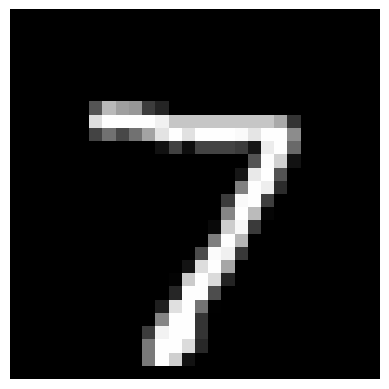

In [21]:
plt.imshow(x_test[0].reshape(28,28).astype(float), cmap='gray');plt.axis("off");plt.show()

<h3> Firstly, feed image to the <b>head</b> model. Then feed the output prediction of the head into the <b>tail</b> model.

<h3> At last, Let's see whether the final prediction is correct?! </h3>

In [22]:
# Create batch size 1
tst = np.expand_dims(x_test[0], 0)

# Do inference by head model
head_pred = head.predict(tst)
print("Output shape of the head model: ",head_pred.shape)

# Do inference by tail model
tail_pred = tail.predict(head_pred)
print("Output shape of the tail model: ",tail_pred.shape)

# Check whether the output is correct or not.
print("Predicted Label:", np.argmax(tail_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Output shape of the head model:  (1, 9, 9, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Output shape of the tail model:  (1, 10)
Predicted Label: 7


<h1 dir='rtl' align='center'>YUP :D</h1>

<h3> Save splitted models </h3>


In [24]:
head.save("head_model.keras")
tail.save("tail_model.keras")

<h2> Merge Head and Tail <h2>

<h3> Merging these two seperated models is too simple! </h3>

In [ ]:
merged_model = keras.Sequential([head, tail], name="merged_model")
merged_model.summary()


Model: "merged_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
head_model (Functional)      (None, 9, 9, 32)          42496     
_________________________________________________________________
tail_model (Functional)      (None, 10)                683722    
Total params: 726,218
Trainable params: 725,738
Non-trainable params: 480
_________________________________________________________________


<h2> Practice: </h2>



1.   The model below is a VGG-style model designed for MNIST dataset. Split it into two parts.
2.   Split a model into more than two parts.



In [ ]:

# Design a VGG-like digit recognition model
model = keras.Sequential(
    [
      keras.Input(shape=input_shape, name="input"),
      KL.Dropout(0.001, name="drop_0"),
      KL.experimental.preprocessing.RandomZoom((-factor, factor), name="zoom"),
      KL.experimental.preprocessing.RandomTranslation((-factor, factor), (-factor, factor), name="translate"),
      KL.experimental.preprocessing.RandomRotation((-factor, factor), name="rotate"),
      KL.experimental.preprocessing.RandomContrast(factor, name="contrast"),

      KL.Conv2D(32, kernel_size=(3, 3), strides=(1,1), name="conv_1"),
      KL.BatchNormalization(name="bn_1"),
      KL.Activation(tf.nn.relu6, name="act_1"),
      # KL.Lambda(relu6, name="act_1"),
      KL.Dropout(0.2, name="drop_1"),
      KL.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), name="conv_2"),
      KL.BatchNormalization(name="bn_2"),
      KL.Activation(tf.nn.relu6, name="act_2"),
      KL.MaxPooling2D(pool_size=(2, 2), name="split"),

      KL.Flatten(name="flatten"),
      KL.Dropout(0.25, name="drop_3"),
      KL.Dense(64, activation="relu", name="dense_1"),
      KL.Dropout(.2, name="drop_4"),
      KL.Dense(num_classes, activation="softmax", name="output"),
    ]
)

# Print a summary of the model
# model.summary(line_length=150)


<h1> END! </h1>

Any kind of contribution is appreciated.

Github: [github.com/nrasadi/split-keras-tensorflow-model](https://github.com/nrasadi/split-keras-tensorflow-model)